# Experiment

In [1]:
import pandas as pd
import numpy as np
import torch
import os
from IPython.display import display

from models import get_global_threshold, get_individual_thresholds
from models import get_global_similarity_log_reg, get_similarity_log_reg
from models import get_embeddings_log_reg
from models import get_global_sim_X_y, get_concept_sim_X_y

from calibration_framework import apply_platt_scaling, apply_isotonic_regression, apply_temperature_scaling
from calibration_framework import apply_histogram_binning, apply_beta_calibration

from utils import compare_all_models_calibration_metric, compare_all_models_calibration_avg, compare_all_models_calibration_concept

In [2]:
dataset_name = 'true-false-dataset'

## 1. Get pre-processed data

In [3]:
metadata_df = pd.read_csv(f'../Data/{dataset_name}/metadata.csv')
embeddings = torch.load(f'Embeddings/{dataset_name}/embeddings.pt')
cosine_similarity_df = pd.read_csv(f'Cosine_Similarities/{dataset_name}/cosine_similarities.csv')

if dataset_name == 'CLEVR':
    metadata_df = metadata_df.drop(['size::large','material::rubber'], axis=1)
    cosine_similarity_df = cosine_similarity_df.drop(['size::large','material::rubber'], axis=1)

concepts = list(cosine_similarity_df.columns)

train_mask = metadata_df['split'] == 'train'
train_embeddings = embeddings[train_mask]
train_metadata_df = metadata_df[train_mask].reset_index(drop=True)
train_cosine_similarity_df = cosine_similarity_df[train_mask].reset_index(drop=True)

cal_mask = metadata_df['split'] == 'calibration'
cal_embeddings = embeddings[cal_mask]
cal_metadata_df = metadata_df[cal_mask].reset_index(drop=True)
cal_cosine_similarity_df = cosine_similarity_df[cal_mask].reset_index(drop=True)

test_mask = metadata_df['split'] == 'test'
test_embeddings = embeddings[test_mask]
test_metadata_df = metadata_df[test_mask].reset_index(drop=True)
test_cosine_similarity_df = cosine_similarity_df[test_mask].reset_index(drop=True)

/tmp/ipykernel_216497/2531076107.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  embeddings = torch.load(f'Embeddings/{dataset_name}/embeddings.pt')


## 2. Train models

In [4]:
m1_models, m1_global_train_error, m1_train_errors = get_global_threshold(train_metadata_df, train_cosine_similarity_df,
                                                                        verbose=False)
m1_train_errors['Model'] = '(M1) Global Threshold'

In [5]:
m2_models, m2_train_errors = get_individual_thresholds(train_metadata_df, train_cosine_similarity_df, verbose=False)
m2_train_errors['Model'] = '(M2) Individual Threshold'

In [6]:
m3_models, m3_global_train_error, m3_train_errors = get_global_similarity_log_reg(train_metadata_df, 
                                                                                  train_cosine_similarity_df,
                                                                                  verbose=False)
m3_train_errors['Model'] = '(M3) Global Similarity LogReg'

In [7]:
m4_models, m4_train_errors = get_similarity_log_reg(train_metadata_df, train_cosine_similarity_df, verbose=False)
m4_train_errors['Model'] = '(M4) Individual Similarity LogReg'

In [8]:
m5_models, m5_train_errors = get_embeddings_log_reg(train_embeddings, train_metadata_df, train_cosine_similarity_df,
                                                   verbose=False)
m5_train_errors['Model'] = '(M5) Embeddings LogReg'

In [9]:
base_models = {'(M1) Global Threshold': m1_models,
          '(M2) Individual Threshold': m2_models,
          '(M3) Global Similarity LogReg': m3_models,
          '(M4) Individual Similarity LogReg': m4_models,
          '(M5) Embeddings LogReg': m5_models
         }

### 2.1 Evaluate training classification error

In [10]:
error_comparison_df = pd.DataFrame.from_dict([m1_train_errors, 
                                              m2_train_errors,
                                              m3_train_errors,
                                              m4_train_errors,
                                              m5_train_errors
                                             ])
error_comparison_df = error_comparison_df.set_index('Model')
if dataset_name == 'CUB':
    error_comparison_df = error_comparison_df.transpose()
    display(error_comparison_df.describe())
else:
    display(error_comparison_df)

,true,animals,cities,companies,elements,facts,generated,inventions
Model,,,,,,,,
(M1) Global Threshold,0.488323,0.017318,0.088166,0.069273,0.008659,0.125426,0.155340,0.070323
(M2) Individual Threshold,0.498819,0.017318,0.079769,0.016793,0.006822,0.092364,0.042771,0.063763
(M3) Global Similarity LogReg,0.498557,0.023616,0.125951,0.124377,0.014957,0.093151,0.125951,0.102335
(M4) Individual Similarity LogReg,0.521648,0.019155,0.083180,0.026502,0.009971,0.096300,0.042771,0.133823
(M5) Embeddings LogReg,0.001050,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## 3. Calibrate models

In [24]:
X_cal, y_cal, _, _ = get_global_sim_X_y(cal_metadata_df, cal_cosine_similarity_df)

m3_models_cal = {}

m3_models_cal['Platt'] = apply_platt_scaling(m3_models, X_cal, y_cal)
m3_models_cal['Isotonic'] = apply_isotonic_regression(m3_models, X_cal, y_cal)
m3_models_cal['Temperature'] = apply_temperature_scaling(m3_models, X_cal, y_cal, verbose=False)

In [25]:
m3_models_cal['Histogram'] = apply_histogram_binning(m3_models, X_cal, y_cal, nbins=10)
m3_models_cal['Beta'] = apply_beta_calibration(m3_models, X_cal, y_cal)

In [13]:
m4_models_cal = {}
m4_models_cal['Platt'] = {}
m4_models_cal['Isotonic'] = {}
m4_models_cal['Temperature'] = {}

m4_models_cal['Histogram'] = {}
m4_models_cal['Beta'] = {}

for concept in m4_models.keys():
    X_cal, y_cal = get_concept_sim_X_y(cal_metadata_df, cal_cosine_similarity_df, concept)

    m4_models_cal['Platt'][concept] = apply_platt_scaling(m4_models[concept], X_cal, y_cal)
    m4_models_cal['Isotonic'][concept] = apply_isotonic_regression(m4_models[concept], X_cal, y_cal)
    m4_models_cal['Temperature'][concept] = apply_temperature_scaling(m4_models[concept], X_cal, y_cal, verbose=False)
    
    m4_models_cal['Histogram'][concept] = apply_histogram_binning(m4_models[concept], X_cal, y_cal, nbins=10)
    m4_models_cal['Beta'][concept] = apply_beta_calibration(m4_models[concept], X_cal, y_cal)

In [14]:
m5_models_cal = {}
m5_models_cal['Platt'] = {}
m5_models_cal['Isotonic'] = {}
m5_models_cal['Temperature'] = {}

m5_models_cal['Histogram'] = {}
m5_models_cal['Beta'] = {}

for concept in m4_models.keys():
    X_cal = cal_embeddings
    y_cal = (cal_metadata_df[concept]==1).to_numpy().astype(int)

    m5_models_cal['Platt'][concept] = apply_platt_scaling(m5_models[concept], X_cal, y_cal)
    m5_models_cal['Isotonic'][concept] = apply_isotonic_regression(m5_models[concept], X_cal, y_cal)
    m5_models_cal['Temperature'][concept] = apply_temperature_scaling(m5_models[concept], X_cal, y_cal, verbose=False)
    
    m5_models_cal['Histogram'][concept] = apply_histogram_binning(m5_models[concept], X_cal, y_cal, nbins=10)
    m5_models_cal['Beta'][concept] = apply_beta_calibration(m5_models[concept], X_cal, y_cal)

In [15]:
calibrated_models = {'(M3) Global Similarity LogReg': m3_models_cal,
                     '(M4) Individual Similarity LogReg': m4_models_cal,
                     '(M5) Embeddings LogReg': m5_models_cal
                    }

## 4. Evaluate models

In [16]:
results_path = f"Results/{dataset_name}/"
os.makedirs(results_path, exist_ok=True)

### 4.1 Get a single metric for all models, calibration methods, and concepts

**Use only if you don't have many concepts!**

In [17]:
metric = 'K1'

if len(concepts) <= 10:
    metric_df = compare_all_models_calibration_metric(base_models, m3_models_cal, m4_models_cal, m5_models_cal,
                                       test_metadata_df, test_cosine_similarity_df, test_embeddings, 
                                       metric=metric)
    if not 'K' in metric:
        display(metric_df.style.highlight_max(color='grey'))
    else:
        display(metric_df)

true   animals    cities  \
Model                             Calibration                                 
(M1) Global Threshold             None                -         -         -   
(M2) Individual Threshold         None                -         -         -   
(M3) Global Similarity LogReg     None         0.239483  0.788014  0.756128   
                                  Histogram    0.267575  0.783821  0.738167   
                                  Isotonic     0.264176  0.744466  0.737107   
                                  Platt        0.229174  0.778164    0.7511   
                                  Temperature  0.114955  0.621486  0.574213   
                                  Beta          0.27866  0.769615  0.730223   
(M4) Individual Similarity LogReg None         0.015215  0.821621  0.680771   
                                  Histogram    0.015571  0.173202  0.665708   
                                  Isotonic     0.030656  0.151383  0.660792   
                                  Platt        0.020356  0.828451  0.668661   
                                  Temperature  0.014569  0.638471  0.537808   
                                  Beta         0.014657  0.832338  0.666016   
(M5) Embeddings LogReg            None         0.473729  0.847292   0.74941   
                                  Histogram    0.391683  0.001631       0.0   
                                  Isotonic     0.390394  0.001934  0.000034   
                                  Platt        0.382279  0.847254  0.749971   
                                  Temperature  0.365292    0.6605  0.615256   
                                  Beta         0.386341  0.847791  0.749404   

                                              companies  elements     facts  \
Model                             Calibration                                 
(M1) Global Threshold             None                -         -         -   
(M2) Individual Threshold         None                -         -         -   
(M3) Global Similarity LogReg     None         0.806532  0.831968  0.699597   
                                  Histogram    0.800655  0.818122  0.714665   
                                  Isotonic     0.802928  0.789642  0.708412   
                                  Platt        0.803178  0.825294  0.692541   
                                  Temperature  0.632625  0.651366  0.549564   
                                  Beta         0.794849   0.80629  0.722799   
(M4) Individual Similarity LogReg None         0.785824  0.850731  0.813125   
                                  Histogram    0.781314  0.812796   0.81141   
                                  Isotonic     0.438218  0.391637  0.584737   
                                  Platt        0.781229  0.856088  0.803515   
                                  Temperature  0.616615  0.659785  0.599914   
                                  Beta          0.78251  0.857576   0.80613   
(M5) Embeddings LogReg            None         0.800823  0.862343  0.908792   
                                  Histogram    0.000517  0.861575  0.905679   
                                  Isotonic     0.000459   0.00188  0.005286   
                                  Platt         0.80113  0.861883  0.907395   
                                  Temperature  0.639019  0.667019  0.688076   
                                  Beta         0.800857  0.861991  0.907987   

                                              generated inventions  
Model                             Calibration                       
(M1) Global Threshold             None                -          -  
(M2) Individual Threshold         None                -          -  
(M3) Global Similarity LogReg     None         0.778906   0.764369  
                                  Histogram    0.829704   0.787198  
                                  Isotonic     0.829373   0.789713  
                                  Platt        0.772694   0.757917  
                     

### 4.2 Get the average of all metrics over the concepts for all models and calibration methods

In [18]:
metrics_avg_df = compare_all_models_calibration_avg(base_models, m3_models_cal, m4_models_cal, m5_models_cal,
                                   test_metadata_df, test_cosine_similarity_df, test_embeddings)
metrics_avg_df.to_csv(os.path.join(results_path, 'metrics_average.csv'))
with open(os.path.join(results_path, 'metrics_average.tex'), 'w') as tf:
     tf.write(metrics_avg_df.to_latex())
    
metrics_avg_df.style.highlight_max(color='grey', subset=['accuracy','f1','auc'])

### 4.3 Get all metrics for all models and calibration methods for a single concept

In [19]:
concept = concepts[0]

metrics_concept_df = compare_all_models_calibration_concept(base_models, m3_models_cal, m4_models_cal, m5_models_cal,
                                   test_metadata_df, test_cosine_similarity_df, test_embeddings,
                                      concept=concept)
metrics_concept_df.to_csv(os.path.join(results_path, f'metrics_concept_{concept}.csv'))
with open(os.path.join(results_path, f'metrics_concept_{concept}.tex'), 'w') as tf:
     tf.write(metrics_concept_df.to_latex())
    
metrics_concept_df.style.highlight_max(color='grey', subset=['accuracy','f1','auc'])  

## Old stuff

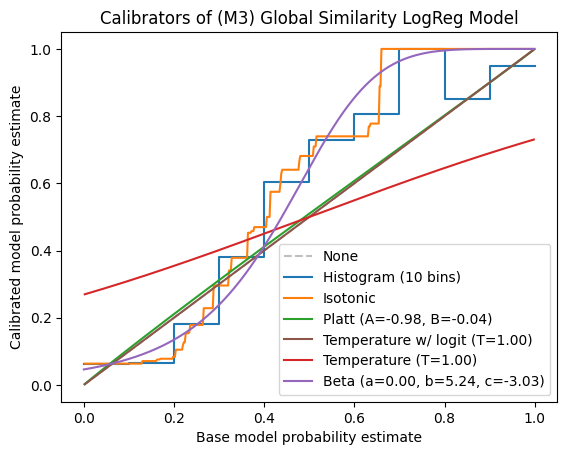

In [36]:
from scipy.special import logit, expit
from matplotlib import pyplot as plt
fig, ax = plt.subplots()

n = 501 # discretization
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# None
plt.plot([0, 1], [0, 1], label = 'None', color = 'grey', linestyle = 'dashed', alpha = 0.5)

# Histogram binning
x_vals = m3_models_cal['Histogram'].calibrator.get_params()['_bin_bounds'][0]
y_vals = m3_models_cal['Histogram'].calibrator.get_params()['_bin_map']
y_vals = np.append(y_vals, y_vals[-1])
nbins = m3_models_cal['Histogram'].calibrator.get_params()['bins']
plt.step(x_vals, y_vals, where = 'post', label = 'Histogram ({} bins)'.format(nbins), color = colors[0])

# Isotonic regression (would be nice if I could find the true bins but this will do)
x_vals = np.linspace(0, 1, num=n, endpoint=True)[1:-1]
y_vals = m3_models_cal['Isotonic'].calibrated_classifiers_[0].calibrators[0].predict(logit(x_vals))
plt.plot(x_vals, y_vals, label = 'Isotonic', color = colors[1])

# Platt scaling
x_vals = np.linspace(0, 1, num=n, endpoint=True)[1:-1]
y_vals = m3_models_cal['Platt'].calibrated_classifiers_[0].calibrators[0].predict(logit(x_vals))
tmp = m3_models_cal['Platt'].calibrated_classifiers_[0].calibrators[0]
a, b = tmp.a_, tmp.b_
plt.plot(x_vals, y_vals, label = 'Platt (A={:.2f}, B={:.2f})'.format(a, b), color = colors[2])

# Temperature scaling

# Emma thinks this should be the correct version (it looks way more believable)
x_vals = np.linspace(0, 1, num=n, endpoint=True)[1:-1]
y_vals = expit(logit(x_vals) / m3_models_cal['Temperature'].temperature)
T = m3_models_cal['Temperature'].temperature
plt.plot(x_vals, y_vals, label = 'Temperature w/ logit (T={:.2f})'.format(T), color = colors[5])

# This matches what the code currently does on data (softmax and no logit)
tmp = m3_models_cal['Temperature']
T = tmp.temperature
x_vals_vec = np.array([1 - x_vals, x_vals]).T
y_vals = tmp.softmax(x_vals_vec / tmp.temperature)[:, 1]
plt.plot(x_vals, y_vals, label = 'Temperature (T={:.2f})'.format(T), color = colors[3])

# Beta calibration
x_vals = np.linspace(0, 1, num=n, endpoint=True)
y_vals = m3_models_cal['Beta'].calibrator.transform(x_vals)
tmp = m3_models_cal['Beta'].calibrator.get_params()
a, b = tmp['_sites']['weights']['values']
c = tmp['_sites']['bias']['values'][0]
plt.plot(x_vals, y_vals, label = 'Beta (a={:.2f}, b={:.2f}, c={:.2f})'.format(a, b, c), color = colors[4])

plt.legend()
ax.set_xlabel('Base model probability estimate')
ax.set_ylabel('Calibrated model probability estimate')
ax.set_title('Calibrators of {} Model'.format('(M3) Global Similarity LogReg'))
plt.show()

In [ ]:
# x_vals = m3_models.predict_proba(X_cal)
# y_vals = m3_models_cal['Platt'].predict_proba(X_cal)
# plt.scatter(x_vals, y_vals, label = 'Platt from data', s = 6, color = 'purple')

# x_vals = m3_models.predict_proba(X_cal)
# y_vals = m3_models_cal['Isotonic'].predict_proba(X_cal)
# plt.scatter(x_vals, y_vals, label = 'Isotonic from data', s = 6, color = 'red')

# x_vals = m3_models.predict_proba(X_cal)
# y_vals = m3_models_cal['Temperature'].predict_proba(X_cal)
# plt.scatter(x_vals, y_vals, label = 'Temperature from data', s = 6, color = 'violet')

# x_vals = m3_models.predict_proba(X_cal)
# y_vals = m3_models_cal['Beta'].predict_proba(X_cal)
# plt.scatter(x_vals, y_vals, label = 'Beta from data', s = 6, color = 'violet') 
# why are a bunch of these giving me double vision, maybe they're giving probabilities for both true and false labels?

# tmp = m3_models_cal['Beta'].calibrator.get_params()
# a, b = tmp['_sites']['weights']['values']
# c = tmp['_sites']['bias']['values'][0]
# y_vals = np.exp(c) * x_vals**a / (1 - x_vals)**b
# y_vals = 1 / (1 + (1/y_vals))
# plt.plot(x_vals, y_vals, label = 'Beta guess')